In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [0]:
train_data = pd.read_csv('train.csv')


In [3]:
train_data.shape

(1306122, 3)

In [0]:
train_data.head()
train_data.dropna(inplace=True)

In [5]:
train_data['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [0]:
# train_data['num_words'] = train_data['question_text'].apply(lambda x: len(str(x).split()) )

In [0]:
X = train_data["question_text"].values
y = train_data['target'].values


In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)

In [9]:
print("Train shape : ",train_X.shape)
print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)


Train shape :  (881631,)
Validation shape :  (97960,)
Test shape :  (326531,)


In [10]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 827085]
 [     1  54546]]
[[    0 91899]
 [    1  6061]]
[[     0 306328]
 [     1  20203]]


In [11]:
testdf = pd.DataFrame()
testdf['question'] = test_X

testdf['target'] = test_y
testdf.shape

(326531, 2)

In [12]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X)

count_vectorizer = CountVectorizer()
count_vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:

train_text_features_cv = count_vectorizer.transform(train_X)
test_text_features_cv = count_vectorizer.transform(test_X)

train_text_features_tf = tfidf_vectorizer.transform(train_X)
test_text_features_tf = tfidf_vectorizer.transform(test_X)

In [0]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

In [0]:
def getROCMetrics(y_test, y_prob_rain):
  fpr, tpr, thresholds = roc_curve(y_test,y_prob_rain[:,1])

  #ROC Curve
  fig,ax1 = plt.subplots(figsize=(9,6))
  ax1.plot(fpr, tpr,color='orange')
  ax1.legend(['ROC Curve'],loc=1)
  ax1.set_xlim([-0.005, 1.0])
  ax1.set_ylim([0,1])
  ax1.set_ylabel('True Positive Rate (Sensitivity)')
  ax1.set_xlabel('False Positive Rate \n(1 - Specificity)\n FP / (TN + FP)')
  ax1.set_title('ROC Curve for RainTomorrow\n')

#   plt.plot([0,1],[0,1],linestyle='--',color='teal')
#   plt.plot([0,1],[0.5,0.5],linestyle='--',color='red',linewidth=0.25)

#   #Threshold Curve
#   ax2 = plt.gca().twinx()
#   ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='black')
#   ax2.legend(['Threshold'],loc=4)
#   ax2.set_ylabel('Threshold',color='black')
#   ax2.set_ylim([0,1])
#   ax2.grid(False)
  
  plt.show()
  
  rf_auc = roc_auc_score(y_test,y_prob_rain[:,1])
  print('AUC Score:', rf_auc*100)
  return rf_auc*100

## **Undersampling**

In [16]:
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
print(sorted(Counter(y_resampled).items()))

[(0, 54546), (1, 54546)]


In [17]:
#without resampling
"""X_resampled = train_text_features_tf
y_resampled = train_y"""

'X_resampled = train_text_features_tf\ny_resampled = train_y'

## Naive Bayes

In [18]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_resampled, y_resampled)



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
# predict the labels on validation dataset
predictions_NB = Naive.predict(test_text_features_tf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, test_y)*100)


Naive Bayes Accuracy Score ->  77.43920179094788


In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(f1_score(predictions_NB, test_y, average="macro"))
print(precision_score(predictions_NB, test_y, average="macro"))
print(recall_score(predictions_NB, test_y, average="macro"))

0.6021909121083557
0.8522707469841835
0.6013802104835033


Sensitivity: 94.11%
Specificity: 76.34%


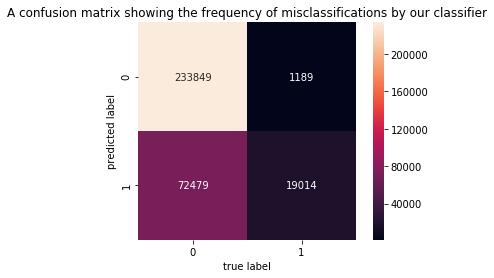

In [21]:
getConfusionMatrix(test_y, predictions_NB)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [0]:
y_prob = Naive.predict_proba(test_text_features_tf)
getROCMetrics(test_text_features_tf, y_prob)


## Support Vector Machine

In [0]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_resampled, y_resampled)



In [0]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(test_text_features_tf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_y)*100)


In [0]:
print(f1_score(predictions_SVM, test_y, average="macro"))
print(precision_score(predictions_SVM, test_y, average="macro"))
print(recall_score(predictions_SVM, test_y, average="macro"))

In [0]:
getConfusionMatrix(test_y, predictions_SVM)

In [0]:
y_prob = SVM.predict_proba(test_text_features_tf)
getROCMetrics(test_text_features_tf, y_prob)
